In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import imageio as io
from PIL import Image

from tqdm.notebook import tqdm
import time

# Task
Approximate
$$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$
where
- $\lambda$ - dimensionless river elevation
- $\tau$ - dimensionless time
- $\chi$ - dimensionless distance
- $\nu$ - dimensionless uplift rate
- $n$ - slope exponent

And there are border and initial functions: $\lambda(0, \tau)$, $\lambda(\chi, 0)$

# Define the parameters

In [2]:
dtau = 0.01
ntau = int(3//dtau)
dchi = 0.01
nchi = int(2//dchi)

#nu = lambda tau, chi: 1/16*(np.array([4, 3, 2, 5, 2])[np.array([-np.inf, 0.2, 0.3, 0.6, 0.8]) <= tau]).sum()
nu = lambda tau, chi: (np.array([0.2, 0.4, 0.7, 0.8, 1.0])[np.array([-np.inf, 0.5, 1, 2, 2.5]) <= tau])[-1]
initial = lambda chi: chi**2
border = lambda tau: 0*tau

ns = [2, 1, 0.5]

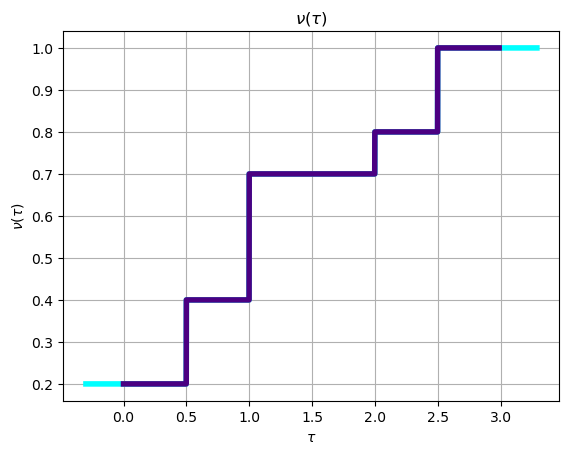

In [3]:
taus = np.arange(-0.1*dtau*ntau, dtau*ntau*1.1, 0.001)
nus = np.array([nu(tau, None) for tau in taus])

plt.figure()
plt.title(r'$\nu(\tau)$')
plt.plot(taus, nus, linewidth=4, color='cyan')
plt.plot(taus[(taus >= 0)&(taus <= dtau*ntau)], nus[(taus >= 0)&(taus <= dtau*ntau)], linewidth=4, color='indigo')
plt.grid(True)
plt.xlabel('$\\tau$')
plt.ylabel('$\\nu(\\tau)$')
plt.savefig("pics/Using dimensionless Uplift rate of time.png")

# The simpliest approximation $O(d\tau +d\chi^{min(1, n)})$


$$
\cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$

We will use $s$ as a $\tau$ step, and $h$ as a $\chi$ step.
Let's use the notation
$$
\lambda_k^j = \lambda(js, kh)
$$
and the similary:
$$
\nu^j = \nu(js, kh)
$$

The simpliest scheme contains the forward derivative over $\tau$ and backward derivative over $\chi$:
$$
\cfrac{\lambda^{j+1}_k - \lambda^j_k}{s} = \nu^j_k - (\cfrac{\lambda^j_{k-1} - \lambda^j_k}{h})^n
$$
$$
\lambda^{j+1}_k = \lambda^j_k + s\cdot\nu^j_k - s(\cfrac{\lambda^j_{k-1} - \lambda^j_k}{h})^n
$$

In [4]:
def approx1(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    L_i^{j+1} = L_i^j + d\tau\cdot\nu(i\cdot d\chi, j\cdot d\tau) + d\tau\cdot(\cfrac{L_i^j - L_{i-1}^j}{d\chi})^n
    $$
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        jnus = np.array([nu(j*dtau, chi) for chi in chis[1:]]) # should add a condition to nu taking array arguments
        sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
            
    return sols, taus, chis

In [5]:
sols = []
for n in ns:
    timer = time.perf_counter()
    sol, taus, chis = approx1(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi)
    print('For solution n={0:.1f} calculated in {1:.4f} seconds.'.format(n, time.perf_counter() - timer))
    sols.append(sol.copy())
print()

filename = 'gifs/approx1.gif'

images = []
for i in tqdm(range(ntau), total=ntau):
    fig = plt.figure()
    for j, sol in enumerate(sols):
        n = ns[j]
        plt.plot(chis, sol[i], label=f'n = {n}')
    plt.title('$\\tau = {0:.4f}$'.format(taus[i]))
    plt.xlabel('$\\chi$')
    plt.ylabel('$\\lambda(\\tau, \\chi)$')
    plt.legend()
    fig.canvas.draw()
    images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
    plt.close(fig)

io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

/tmp/ipykernel_22788/2523524694.py:60: RuntimeWarning: overflow encountered in square
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
/tmp/ipykernel_22788/2523524694.py:60: RuntimeWarning: invalid value encountered in subtract
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
/tmp/ipykernel_22788/2523524694.py:60: RuntimeWarning: invalid value encountered in sqrt
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n


For solution n=2.0 calculated in 0.1971 seconds.
For solution n=1.0 calculated in 0.1969 seconds.
For solution n=0.5 calculated in 0.1972 seconds.



  0%|          | 0/299 [00:00<?, ?it/s]

generated and saved to path gifs/approx1.gif


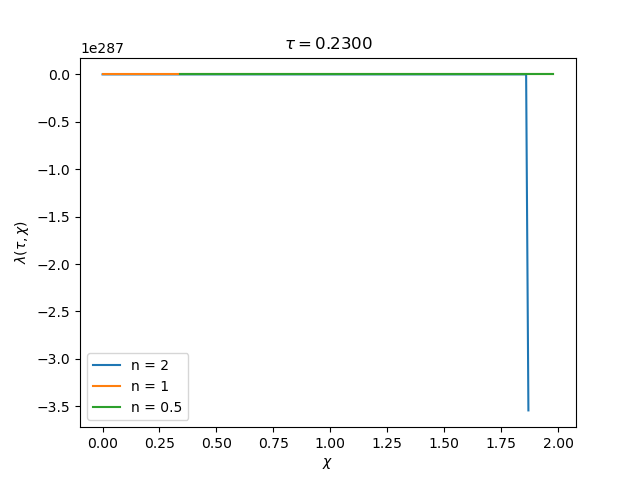

In [6]:
# Choose the the latest image containing big absolute value
sols = np.array(sols)
image_index = abs(sols)*np.arange(ntau).reshape([1, ntau, 1])
image_index = np.where(image_index == np.unique(image_index)[-2])[1][0]
images[image_index]

__Conclusion:__ It's unstable

# Jean Braun, Sean D. Willetts

The previous scheme was totally unstable. but there is an Jean Braun, Sean D. Willetts [article](https://www.sciencedirect.com/science/article/abs/pii/S0169555X12004618) with modificated similar scheme.

## Equation
This scheme should approximate the equation:
$$
    \cfrac{\partial h}{\partial t} = -KA^m(\cfrac{\partial h}{\partial x})^n
$$
in our language it will be
$$
    \cfrac{\partial\lambda}{\partial\tau} = -KA^m(\cfrac{\partial\lambda}{\partial\chi})^n
$$

So it's just an another equation than ours
$$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$

To compare this scheme with ours, let's set $\nu = 0$ and $KA^m = 1$ ($K=1, A=1, m=0$)
$$
    \cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = 0
$$

Let's check how stable our scheme is when $\nu(\chi, \tau) = 0$

In [7]:
nu0 = lambda tau, chi: 0

sols = []
for n in ns:
    timer = time.perf_counter()
    sol, taus, chis = approx1(nu0, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi)
    print('For solution n={0:.1f} calculated in {1:.4f} seconds.'.format(n, time.perf_counter() - timer))
    sols.append(sol.copy())
print()

filename = 'gifs/approx1nu0.gif'

images = []
for i in tqdm(range(ntau), total=ntau):
    fig = plt.figure()
    for j, sol in enumerate(sols):
        n = ns[j]
        plt.plot(chis, sol[i], label=f'n = {n}')
    plt.title('$\\tau = {0:.4f}$'.format(taus[i]))
    plt.xlabel('$\\chi$')
    plt.ylabel('$\\lambda(\\tau, \\chi)$')
    plt.legend()
    fig.canvas.draw()
    images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
    plt.close(fig)

io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

For solution n=2.0 calculated in 0.0132 seconds.
For solution n=1.0 calculated in 0.0117 seconds.
For solution n=0.5 calculated in 0.0118 seconds.



/tmp/ipykernel_22788/2523524694.py:60: RuntimeWarning: overflow encountered in square
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
/tmp/ipykernel_22788/2523524694.py:60: RuntimeWarning: invalid value encountered in subtract
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
/tmp/ipykernel_22788/2523524694.py:60: RuntimeWarning: invalid value encountered in sqrt
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n


  0%|          | 0/299 [00:00<?, ?it/s]

generated and saved to path gifs/approx1nu0.gif


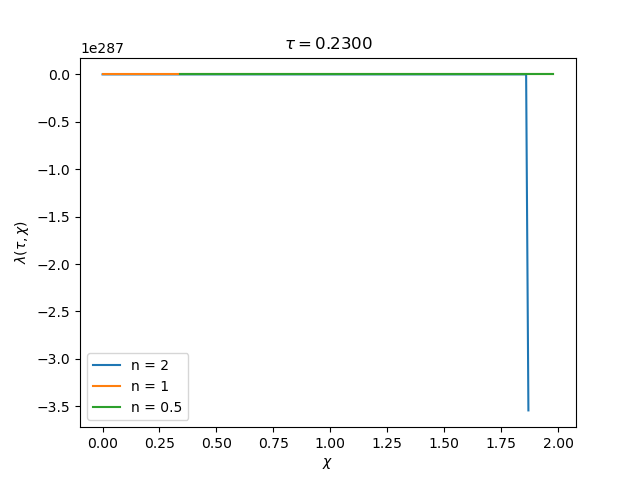

In [8]:
# Choose the the latest image containing big absolute value
sols = np.array(sols)
image_index = abs(sols)*np.arange(ntau).reshape([1, ntau, 1])
image_index = np.where(image_index == np.unique(image_index)[-2])[1][0]
images[image_index]

__Conclusion:__ When $\nu(\tau, \chi) = 0$, the scheme is also unstable.

## Scheme
I'll describe the scheme using both notations: mine and the article outors.

The first author defines a simple first-order finite difference schemes to compute both the spatial derivative (the slope) of the height field and its time derivative:
$$
    \cfrac{\partial h(i)}{\partial x} = \cfrac{h^{t}(r(i)) - h^{t}(i)}{\Delta x_i}
$$
$$
    \cfrac{\partial h(i)}{\partial t} = \cfrac{h^{t + \Delta t}(i) - h^{t}(i)}{\Delta t}
$$
In our notation this will be:
$$
{\cfrac{\partial\lambda}{\partial\tau}}_k^j = 
\cfrac{\lambda_k^{j+1} - \lambda_k^j}{s} 
$$
$$
{\cfrac{\partial\lambda}{\partial\chi}}_k^j = 
\cfrac{\lambda_{k+1}^j - \lambda_k^j}{h} 
$$

Jean Braun and Sean D. Willett do not calculate the value in middle grid poin, as I am going to do later, and represent the scheme by 2 derivatives near new point:
$$
\cfrac{h^{t+\Delta t}(s(i)) - h^{t}(s(i))}{\Delta t} = 
-KA^m(\cfrac{h^{t+\Delta t}(s(i)) - h^{t+\Delta t}(r(s(i)))}{\Delta x_i})^n
$$
In our notation this will be:
$$
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1}}{s} = 
-KA^m(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n
$$
and then authors get the value $\lambda^{j+1}_{k+1}$ by solving nonlinear equation:
$$
h^{t+\Delta t}(s(i)) - h^t(s(i)) + KA^m\Delta t(\cfrac{h^{t+\Delta t}(s(i)) - h^{t+\Delta t}(r(s(i)))}{\Delta x_i})^n = 0
$$
in our notation:
$$
F(\lambda^{j+1}_{k+1}) = 
\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1} + KA^m\cdot s(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n = 0
$$
and it's derivative is
$$
\cfrac{\partial F}{\partial \lambda^{j+1}_{k+1}} (\lambda^{j+1}_{k+1}) = 
1 + KA^m\cdot\cfrac{s}{h}(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^{n-1}
$$

Let's check, how better it is!

In [9]:
def approx1braun(K, A, m, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000, 
                 method=sp.optimize.fsolve, use_fprime=True, bar=None):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    \lambda^{j+1}_{k+1} - \lambda^{j}_{k+1} + KA^m\cdot s(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n = 0
    $$
    
    Parameters:
    -----------
    K, A, m: float constants
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    method : function
        Method to solve nonlinear equation
        
    use_fprime : bool
        Use an analytical derivative as fprime parameter in method
        
    bar: tqdm bar or None:
        bar to update each iteration.
        Not draw bar if it's None
        
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        for k in range(nchi - 1):
            f = lambda sol: sol - sols[j, k+1] + K*A**m*dtau*((sol - sols[j+1, k])/dchi)**n
            if use_fprime:
                fprime = lambda sol: 1 + (K*A**m*dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
                sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime)
            else:
                sols[j+1, k+1] = method(f, x0=sols[j, k]) 
            if bar is not None:
                bar.update()
    return sols, taus, chis
    

In [10]:
K, A, m = 1, 1, 0

nu0 = lambda tau, chi: 0

sols = []
for n in ns:
    timer = time.perf_counter()
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx1braun(K, A, m, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
    print('For solution n={0:.1f} calculated in {1:.4f} seconds.'.format(n, time.perf_counter() - timer))
    sols.append(sol.copy())
print()

filename = 'gifs/approx1braun.gif'

images = []
for i in tqdm(range(ntau), total=ntau):
    fig = plt.figure()
    for j, sol in enumerate(sols):
        n = ns[j]
        plt.plot(chis, sol[i], label=f'n = {n}')
    plt.title('$\\tau = {0:.4f}$'.format(taus[i]))
    plt.xlabel('$\\chi$')
    plt.ylabel('$\\lambda(\\tau, \\chi)$')
    plt.legend()
    fig.canvas.draw()
    images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
    plt.close(fig)

io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

Approximating over grid for n = 2


  0%|          | 0/59004 [00:00<?, ?it/s]

For solution n=2.0 calculated in 5.3280 seconds.
Approximating over grid for n = 1


  0%|          | 0/59004 [00:00<?, ?it/s]

For solution n=1.0 calculated in 5.7065 seconds.
Approximating over grid for n = 0.5


/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


  0%|          | 0/59004 [00:00<?, ?it/s]

For solution n=0.5 calculated in 4.2998 seconds.



/tmp/ipykernel_22788/3237746792.py:73: RuntimeWarning: divide by zero encountered in power
  fprime = lambda sol: 1 + (K*A**m*dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
/tmp/ipykernel_22788/3237746792.py:71: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: sol - sols[j, k+1] + K*A**m*dtau*((sol - sols[j+1, k])/dchi)**n


  0%|          | 0/299 [00:00<?, ?it/s]

generated and saved to path gifs/approx1braun.gif


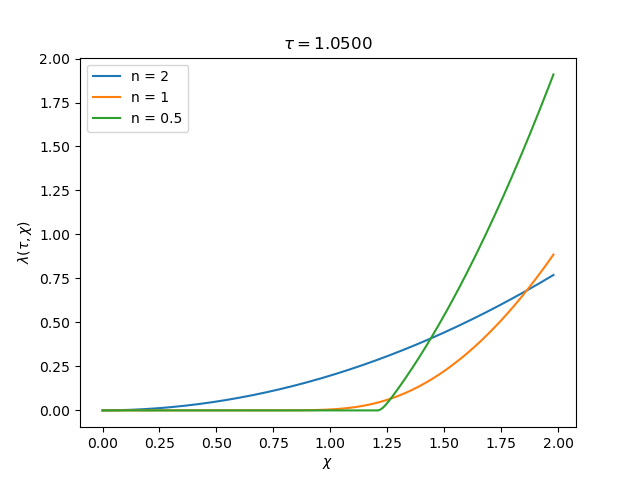

In [11]:
# Choose the the latest image containing big absolute value
sols = np.array(sols)
image_index = abs(sols)*np.arange(ntau).reshape([1, ntau, 1])
image_index = np.where(image_index == np.unique(image_index)[-2])[1][0]
images[image_index]

__Conclusion:__ Jean Braun and Sean Willetts method works well, but it solves another equation, that I need.

# Nonlinear approximation $O(d\tau +d\chi^{min(1, n)})$

Let's make the same representation, as Braun and Willet did:
$$
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1}}{s} = \nu^{j+1}_{k+1} - (
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n
$$

To find the approximation of $\lambda^{j+1}_{k+1}$ we should solve a nonlinear equation $F(\lambda^{j+1}_{k+1}) = 0$ where
$$
F(\lambda^{j+1}_{k+1}) = \lambda^{j+1}_{k+1} - \lambda^{j}_{k+1} + 
s(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n - s\nu^{j+1}_{k+1}
$$
and
$$
\cfrac{\partial F}{\partial \lambda^{j+1}_{k+1}}(\lambda^{j+1}_{k+1}) = 
1 - \cfrac{s}{h}(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^{n-1}
$$

In [12]:
def approx1nonlinear(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000, 
                     method=sp.optimize.fsolve, use_fprime=True, bar=None):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    \cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1}}{s} = \nu^{j+1}_{k+1} - (
    \cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n
    $$
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    method : function
        Method to solve nonlinear equation
        
    use_fprime : bool
        Use an analytical derivative as fprime parameter in method
        
    bar: tqdm bar or None:
        bar to update each iteration.
        Not draw bar if it's None
        
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        for k in range(nchi - 1):
            f = lambda sol: sol - sols[j, k+1] + dtau*((sol - sols[j+1, k])/dchi)**n - dtau*nu((j+1)*dtau, (k+1)*dchi)
            if use_fprime:
                fprime = lambda sol: 1 - (dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
                sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime)
            else:
                sols[j+1, k+1] = method(f, x0=sols[j, k]) 
            if bar is not None:
                bar.update()
    return sols, taus, chis

In [13]:
sols = []
for n in ns:
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx1nonlinear(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
    sols.append(sol.copy())

filename = 'gifs/approx1nonlinear.gif'

print('Generating gif-frames')
images = []
for i in tqdm(range(ntau), total=ntau):
    fig = plt.figure()
    for j, sol in enumerate(sols):
        n = ns[j]
        plt.plot(chis, sol[i], label=f'n = {n}')
    plt.title('$\\tau = {0:.4f}$'.format(taus[i]))
    plt.xlabel('$\\chi$')
    plt.ylabel('$\\lambda(\\tau, \\chi)$')
    plt.legend()
    fig.canvas.draw()
    images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
    plt.close(fig)

print('Compile to gif-file...')
io.mimsave(filename, images, fps=12, loop=0)
print(f'Saved to path {filename}')

Approximating over grid for n = 2


  0%|          | 0/59004 [00:00<?, ?it/s]

Approximating over grid for n = 1


  0%|          | 0/59004 [00:00<?, ?it/s]

Approximating over grid for n = 0.5


  0%|          | 0/59004 [00:00<?, ?it/s]

Generating gif-frames


/tmp/ipykernel_22788/2679813766.py:74: RuntimeWarning: divide by zero encountered in power
  fprime = lambda sol: 1 - (dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
/tmp/ipykernel_22788/2679813766.py:72: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: sol - sols[j, k+1] + dtau*((sol - sols[j+1, k])/dchi)**n - dtau*nu((j+1)*dtau, (k+1)*dchi)
/tmp/ipykernel_22788/2679813766.py:74: RuntimeWarning: invalid value encountered in power
  fprime = lambda sol: 1 - (dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)


  0%|          | 0/299 [00:00<?, ?it/s]

Compile to gif-file...
Saved to path gifs/approx1nonlinear.gif


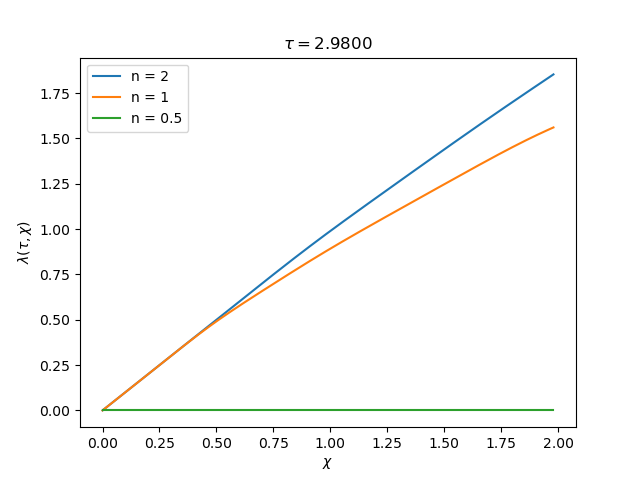

In [14]:
# Choose the the latest image containing big absolute value
sols = np.array(sols)
image_index = abs(sols)*np.arange(ntau).reshape([1, ntau, 1])
image_index = np.where(image_index == np.unique(image_index)[-2])[1][0]
images[image_index]

__Conclusion:__ And the result is stable!

# Approximation by nonlinear way $O(d\tau^{min(2, 3n)} +d\chi^{min(2, 2n)})$

$$
\cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$

We will use $s$ as a $\tau$ step, and $h$ as a $\chi$ step.
Let's use the notation
$$
\lambda_k^j = \lambda(js, kh)
$$
and the similary:
$$
\nu^j = \nu(js, kh)
$$
$$
\cfrac{\partial\lambda}{\partial\tau}_k^j = \cfrac{\partial\lambda}{\partial\tau}(js, kh)
$$
$$
\cfrac{\partial^2\lambda}{\partial\tau^2}_k^j = \cfrac{\partial^2\lambda}{\partial\tau^2}(js, kh)
$$
$$
\cfrac{\partial\lambda}{\partial\chi}_k^j = \cfrac{\partial\lambda}{\partial\chi}(js, kh)
$$
$$
\cfrac{\partial^2\lambda}{\partial\chi^2}_k^j = \cfrac{\partial^2\lambda}{\partial\chi^2}(js, kh)
$$

Now let's represent $\lambda^{j+1}_{k+1}$, $\lambda^{j+1}_{k+1}$, $\lambda^{j+1}_{k+1}$ and $\lambda^{j+1}_{k+1}$ in the terms of Taylor series near point $((j+0.5)s, (k+0.5)h)$:
$$
\lambda^{j+1}_{k+1} = 
\lambda^{j+0.5}_{k+0.5} + 
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} + 
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} + 
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$
$$
\lambda^{j+1}_{k} = 
\lambda^{j+0.5}_{k+0.5} + 
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} -
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} -
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} +
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$
$$
\lambda^{j}_{k+1} = 
\lambda^{j+0.5}_{k+0.5} -
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} + 
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} -
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$
$$
\lambda^{j}_{k} = 
\lambda^{j+0.5}_{k+0.5} -
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} -
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} +
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$



We can approximate the derivatives:
$$
\cfrac{\partial\lambda}{\partial\tau}_{k+0.5}^{j+0.5} =
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + O(s^2 + h^3)
$$

$$
\cfrac{\partial\lambda}{\partial\chi}_{k+0.5}^{j+0.5} =
\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h} + O(s^3 + h^2)
$$

So we also can approximate:
$$
{\cfrac{\partial\lambda}{\partial\tau}}_{k+0.5}^{j+0.5} + ({\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5})^n = 
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + 
(\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h})^n + 
O(s^{min(2, 3n)} + h^{min(2, 2n)})
$$

And the scheme will be:
$$
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + 
(\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h})^n -
\nu^{j+0.5}_{k+0.5} = 0
$$

And we should solve nonlinear equation $F(\lambda_{k+1}^{j+1}) = 0$ to find an element $\lambda_{k+1}^{j+1}$, where
$$
F(\lambda_{k+1}^{j+1}) = 
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + 
(\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h})^n -
\nu^{j+0.5}_{k+0.5}
$$

We can solve this equation using methods like [Newton](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton) or any [other](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding). I prefer [scipy fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html), cause it's faster. 

And we can use the analytical derivatives for these solving methods:
$$
\cfrac{\partial F}{\partial \lambda_{k+1}^{j+1}}(\lambda_{k+1}^{j+1}) = 
\cfrac{1}{2s} + \cfrac{1}{(2h)^n}\cdot(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j)^{n-1}
$$
$$
\cfrac{\partial^2 F}{\partial {\lambda_{k+1}^{j+1}}^2}(\lambda_{k+1}^{j+1}) = 
\cfrac{1}{(2h)^n}\cdot(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j)^{n-2}
$$

In [15]:
def approx2nonlinear(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000, 
                     method=sp.optimize.fsolve, use_fprime=True, bar=None):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    \cfrac{1}{2s}(\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j) = 
    \nu((j+0.5)s, (k+0.5)h) - 
    (\cfrac{1}{2h}(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j))^n + 
    O(s + h^n)
    $$
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    method : function
        Method to solve nonlinear equation
        
    use_fprime : bool
        Use an analytical derivative as fprime parameter in method
        
    bar: tqdm bar or None:
        bar to update each iteration.
        Not draw bar if it's None
        
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        for k in range(nchi - 1):
            f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu((j + 0.5)*dtau, (k + 0.5)*dchi)
            if use_fprime:
                fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)
                fprime2 = lambda sol: (0.5/dchi)**2 * (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 2)
                try:
                    sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime, fprime2=fprime2)
                except TypeError:
                    sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime)
            else:
                sols[j+1, k+1] = method(f, x0=sols[j, k]) 
            if bar is not None:
                bar.update()
    return sols, taus, chis

In [16]:
sols = []
for n in ns:
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx2nonlinear(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
    sols.append(sol.copy())

filename = 'gifs/approx2nonlinear.gif'

print('Generating gif-frames')
images = []
for i in tqdm(range(ntau), total=ntau):
    fig = plt.figure()
    for j, sol in enumerate(sols):
        n = ns[j]
        plt.plot(chis, sol[i], label=f'n = {n}')
    plt.title('$\\tau = {0:.4f}$'.format(taus[i]))
    plt.xlabel('$\\chi$')
    plt.ylabel('$\\lambda(\\tau, \\chi)$')
    plt.legend()
    fig.canvas.draw()
    images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
    plt.close(fig)

print('Compile to gif-file...')
io.mimsave(filename, images, fps=12, loop=0)
print(f'Saved to path {filename}')

Approximating over grid for n = 2


  0%|          | 0/59004 [00:00<?, ?it/s]

Approximating over grid for n = 1


/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


  0%|          | 0/59004 [00:00<?, ?it/s]

Approximating over grid for n = 0.5


  0%|          | 0/59004 [00:00<?, ?it/s]

Generating gif-frames


/tmp/ipykernel_22788/1815050137.py:74: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu((j + 0.5)*dtau, (k + 0.5)*dchi)
/tmp/ipykernel_22788/1815050137.py:76: RuntimeWarning: invalid value encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)
/tmp/ipykernel_22788/1815050137.py:76: RuntimeWarning: divide by zero encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)


  0%|          | 0/299 [00:00<?, ?it/s]

Compile to gif-file...
Saved to path gifs/approx2nonlinear.gif


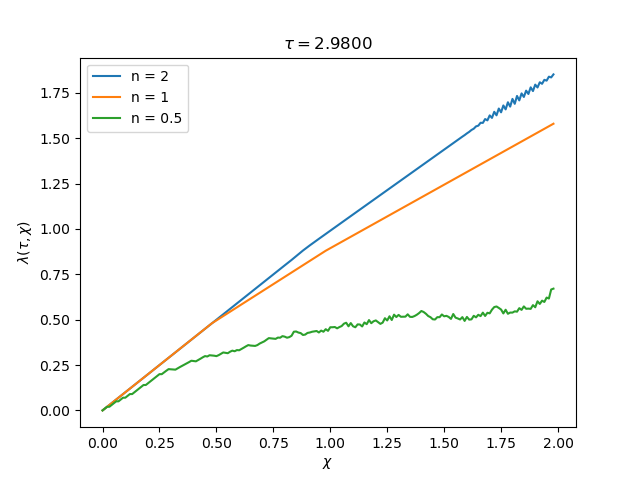

In [17]:
# Choose the the latest image containing big absolute value
sols = np.array(sols)
image_index = abs(sols)*np.arange(ntau).reshape([1, ntau, 1])
image_index = np.where(image_index == np.unique(image_index)[-2])[1][0]
images[image_index]

## Comparing methods of solving nonlinear methods

In [18]:
methods = [sp.optimize.fsolve, sp.optimize.newton, sp.optimize.root_scalar]

sols_use_fprime_true = []
sols_use_fprime_false = []

timers = []


with tqdm(total=2*len(methods)*len(ns)*(ntau - 1)*(nchi - 1)) as pbar:
    counter = 0
    for n in ns:
        for i, method in enumerate(methods):
            # 1st subcycle: use_fprime = True
            use_fprime = True
            counter += 1
            pbar.set_postfix_str(f'{counter}/{2*len(ns)*len(methods)}: n={n}, method={method.__name__}, use_fprime={use_fprime}')
            pbar.refresh()
            
            timer = time.perf_counter()
            sol, taus, chis = approx2nonlinear(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
            timer = time.perf_counter() - timer
            timers.append({'n': n, 'method': method.__name__, 'use_fprime': use_fprime, 'time': timer})
            sols_use_fprime_true.append(sol.copy())
            
            # 2nd subcycle: use_fprime = False
            use_fprime = False
            counter += 1
            pbar.set_postfix_str(f'{counter}/{2*len(ns)*len(methods)}: n={n}, method={method.__name__}, use_fprime={use_fprime}')
            pbar.refresh()
            
            timer = time.perf_counter()
            sol, taus, chis = approx2nonlinear(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
            timer = time.perf_counter() - timer
            timers.append({'n': n, 'method': method.__name__, 'use_fprime': use_fprime, 'time': timer})
            sols_use_fprime_false.append(sol.copy())
            

timers = pd.DataFrame(timers).pivot(index=['method', 'use_fprime'], columns='n')
timers

  0%|          | 0/1062072 [00:00<?, ?it/s]

/tmp/ipykernel_22788/1815050137.py:74: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu((j + 0.5)*dtau, (k + 0.5)*dchi)
/tmp/ipykernel_22788/1815050137.py:76: RuntimeWarning: invalid value encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)
/tmp/ipykernel_22788/1815050137.py:76: RuntimeWarning: divide by zero encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)


time                      
n                             0.5        1.0        2.0
method      use_fprime                                 
fsolve      False       13.641218  17.842900  13.190183
            True        13.798052  17.989726  13.199567
newton      False       13.798838  17.894553  13.240113
            True        13.806792  17.976280  13.183672
root_scalar False       13.664329  17.938183  13.225176
            True        13.753897  17.759729  13.203767

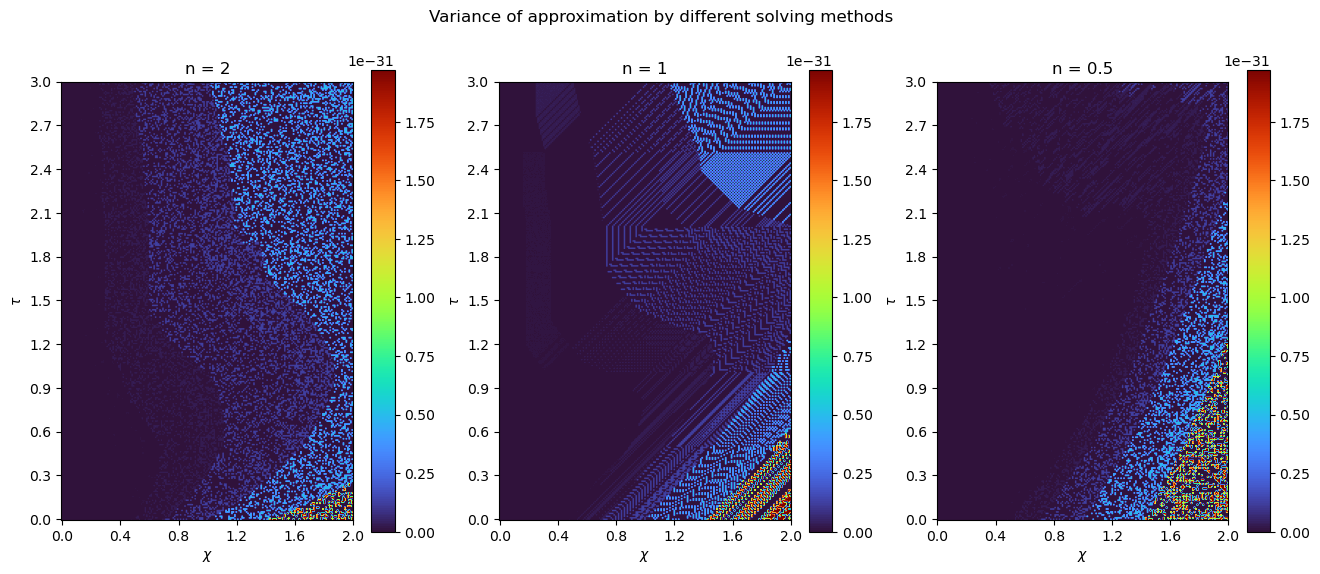

In [19]:
fig, axs = plt.subplots(1, len(ns))
fig.set_figheight(6)
fig.set_figwidth(5*len(ns) + 1)
fig.suptitle('Variance of approximation by different solving methods')

xticks = np.linspace(0, len(chis), 6)
yticks = np.linspace(0, len(taus), 11)

for i, n in enumerate(ns):
    sols_methods = np.concatenate([sols_use_fprime_true[i*len(methods): (i + 1)*len(methods)], 
                                   sols_use_fprime_false[i*len(methods): (i + 1)*len(methods)]])
    
    axs[i].set_title(f'n = {n}')
    mappable = axs[i].imshow(sols_methods.var(axis=0), origin='lower', cmap='turbo')
    plt.colorbar(mappable)
    
    axs[i].set_xticks(xticks, np.round(xticks*dchi, 1))
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_yticks(yticks, np.round(yticks*dtau, 1))
    axs[i].set_ylabel(r'$\tau$')
    
fig.savefig('pics/Variance of approximation by different solving methods.png')

__Conclusion:__ The approximation do not depend on solving nonlinear equation method. So errors should be the result of scheme accuracy.

## Continuosing $\nu(\tau, \chi)$

There is the hypothesis, that previous scheme instability is the result of $\nu(\tau, \chi)$ is not stable.
Let's check this by changing $\nu^{j+0.5}_{k+0.5}$ to ${\nu^C}^{j+0.5}_{k+0.5}$, where 
$$
\nu^C (\tau, \chi) = 
\cfrac{1}{hs}
\int\limits_{\tau - 0.5\cdot d\tau}^{\tau + 0.5\cdot d\tau}
\int\limits_{\chi - 0.5\cdot d\chi}^{\chi + 0.5\cdot d\chi}
\nu(\tau\prime, \chi\prime) d\chi\prime d\tau\prime
$$

In [20]:
nu_continous = lambda tau, chi: sp.integrate.dblquad(nu, 
                                                     tau - 0.5*dtau, tau + 0.5*dtau,
                                                     chi - 0.5*dchi, chi + 0.5*dchi)[0]/(dtau*dchi)
nu_continous = lambda tau, chi: sp.integrate.quad(lambda tauprime: nu(tauprime, 0), 
                                                  tau - 0.5*dtau, tau + 0.5*dtau)[0] / dtau


In [21]:
def nu(tau, chi):
    return (np.array([0.2, 0.4, 0.7, 0.8, 1.0])[np.array([-np.inf, 0.5, 1, 2, 2.5]) <= tau])[-1]

def nu_continous(tau, chi):
    if tau < 0.5 - dchi:
        return 0.2
    if tau < 0.5 + dchi:
        t = 0.5*(0.5 + dchi - tau)/dchi
        return 0.2*t + 0.4*(1 - t)
    if tau < 1.0 - dchi:
        return 0.4
    if tau < 1.0 + dchi:
        t = 0.5*(1.0 + dchi - tau)/dchi
        return 0.4*t + 0.7*(1 - t)
    if tau < 2.0 - dchi:
        return 0.7
    if tau < 2.0 + dchi:
        t = 0.5*(2.0 + dchi - tau)/dchi
        return 0.7*t + 0.8*(1 - t)
    if tau < 2.5 - dchi:
        return 0.8
    if tau < 2.5 + dchi:
        t = 0.5*(2.5 + dchi - tau)/dchi
        return 0.8*t + 1.0*(1 - t)
    return 1.0

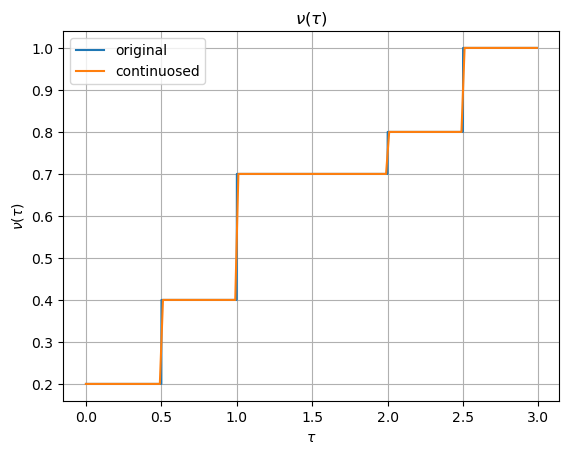

In [22]:
taus = np.arange(0, dtau*ntau, 1e-4)
nus = np.array([nu(tau, 0) for tau in taus])
nus_c = np.array([nu_continous(tau, 0) for tau in taus])
#nus_m4 = np.array([nu_mean4(tau, 0) for tau in taus])

plt.figure()
plt.title(r'$\nu(\tau)$')
plt.plot(taus, nus, label='original')
plt.plot(taus, nus_c, label='continuosed')
#plt.plot(taus, nus_m4, label='mean by 4 points')
plt.grid(True)
plt.xlabel('$\\tau$')
plt.ylabel('$\\nu(\\tau)$')
plt.legend()

plt.show()

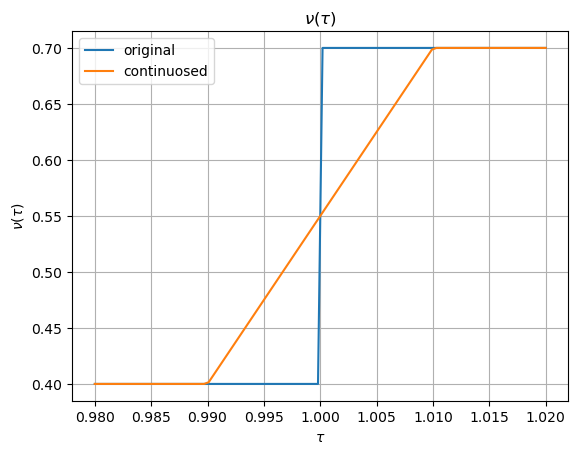

In [23]:
taus = np.linspace(1-2*dtau, 1+2*dtau, 100)

nus = np.array([nu(tau, 0) for tau in taus])
nus_c = np.array([nu_continous(tau, 0) for tau in taus])

plt.figure()
plt.title(r'$\nu(\tau)$')
plt.plot(taus, nus, label='original')
plt.plot(taus, nus_c, label='continuosed')

plt.grid(True)
plt.xlabel('$\\tau$')
plt.ylabel('$\\nu(\\tau)$')
plt.legend()

plt.show()

Let's compare continuous and non-continuous $\nu$

In [24]:
nu_funs = [nu, nu_continous]

timers = []

nusols = []
with tqdm(total=len(nu_funs)*len(ns)*(ntau - 1)*(nchi - 1)) as pbar:
    counter = 0
    for nu_fun in nu_funs:
        sols = []
        for n in ns:
            counter += 1
            pbar.set_postfix_str(f'{counter}/{len(ns)*len(nu_funs)}: n={n}, nu={nu_fun.__name__}')
            pbar.refresh()
            
            timer = time.perf_counter()
            sol, taus, chis = approx2nonlinear(nu_fun, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
            timer = time.perf_counter() - timer
            timers.append({'n': n, 'nu': nu_fun.__name__, 'time': timer})
            
            sols.append(sol.copy())
        nusols.append(sols)
    
nusols = np.array(nusols)
print(f'nusols.shape = {nusols.shape}')

timers = pd.DataFrame(timers).pivot(index='nu', columns='n')
timers

  0%|          | 0/354024 [00:00<?, ?it/s]

/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_22788/1815050137.py:74: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu((j + 0.5)*dtau, (k + 0.5)*dchi)
/tmp/ipykernel_22788/1815050137.py:76: RuntimeWarning: invalid value encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)
/tmp/ipykernel_22788/1815050137.py:76: RuntimeWarning: d

nusols.shape = (2, 3, 299, 199)


time                      
n                   0.5        1.0        2.0
nu                                           
nu            13.750012  17.848792  13.242872
nu_continous  11.729808  15.007119  10.956816

In [28]:
filename = 'gifs/approx2nonlinear-nus.gif'

print('Generating gif-frames')
images = []
for i in tqdm(range(ntau), total=ntau):
    fig, axs = plt.subplots(1, len(nu_funs))
    fig.set_figwidth(4*len(nu_funs))
    fig.set_figheight(3)
    fig.suptitle('$\\tau = {0:.4f}$'.format(taus[i]))
    
    for k, sols in enumerate(nusols):
        for j, sol in enumerate(sols):
            n = ns[j]
            axs[k].plot(chis, sol[i], label=f'n = {n}')
        axs[k].set_title(f'nu={nu_funs[k].__name__}')
        axs[k].set_xlabel(r'$\chi$')
        axs[k].set_ylabel(r'$\lambda(\tau, \chi)$')
        axs[k].legend()
    fig.canvas.draw()
    images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
    plt.close(fig)


    
print('Compile to gif-file...')
io.mimsave(filename, images, fps=12, loop=0)
print(f'Saved to path {filename}')

Generating gif-frames


  0%|          | 0/299 [00:00<?, ?it/s]

Compile to gif-file...
Saved to path gifs/approx2nonlinear-nus.gif


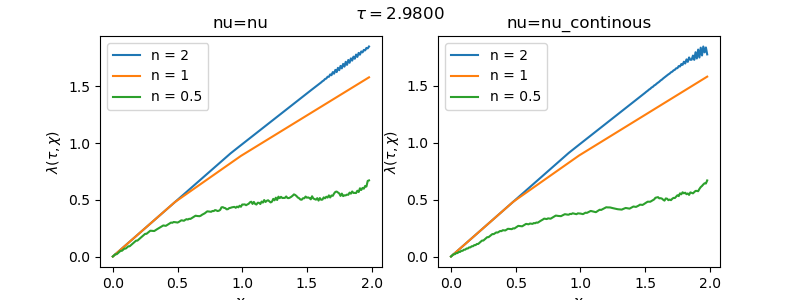

In [40]:
# Choose the the latest image containing big absolute value
imsols = np.array(nusols)
image_index = abs(imsols)*np.arange(ntau).reshape([1, 1, ntau, 1])
image_index = np.where(image_index == np.unique(image_index)[-2])[2][0]
images[image_index]

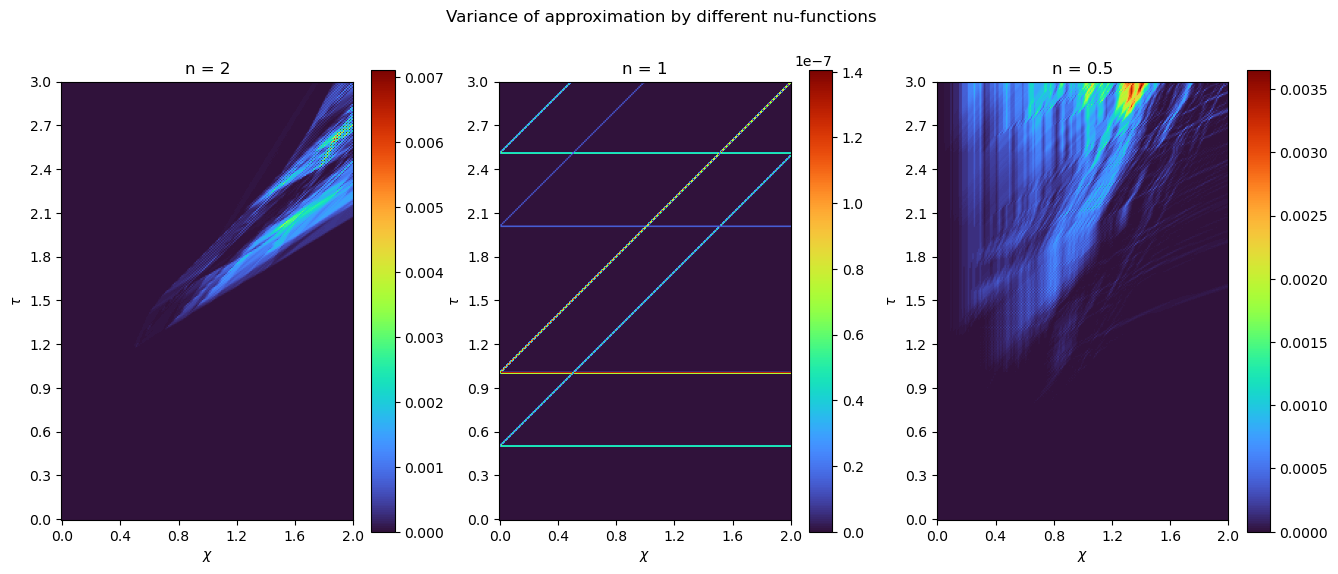

In [26]:
fig, axs = plt.subplots(1, len(ns))
fig.set_figheight(6)
fig.set_figwidth(5*len(ns) + 1)
fig.suptitle('Variance of approximation by different nu-functions')

xticks = np.linspace(0, len(chis), 6)
yticks = np.linspace(0, len(taus), 11)

for i, n in enumerate(ns):
    sols_n = nusols[:, i, :, :]
    
    axs[i].set_title(f'n = {n}')
    mappable = axs[i].imshow(sols_n.var(axis=0), origin='lower', cmap='turbo')
    plt.colorbar(mappable)
    
    axs[i].set_xticks(xticks, np.round(xticks*dchi, 1))
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_yticks(yticks, np.round(yticks*dtau, 1))
    axs[i].set_ylabel(r'$\tau$')
    
fig.savefig('pics/Variance of approximation by different solving methods.png')

/tmp/ipykernel_22788/425630573.py:13: RuntimeWarning: invalid value encountered in divide
  mappable = axs[i].imshow(sols_n.var(axis=0)**0.5/(sols_n.max(axis=0)),


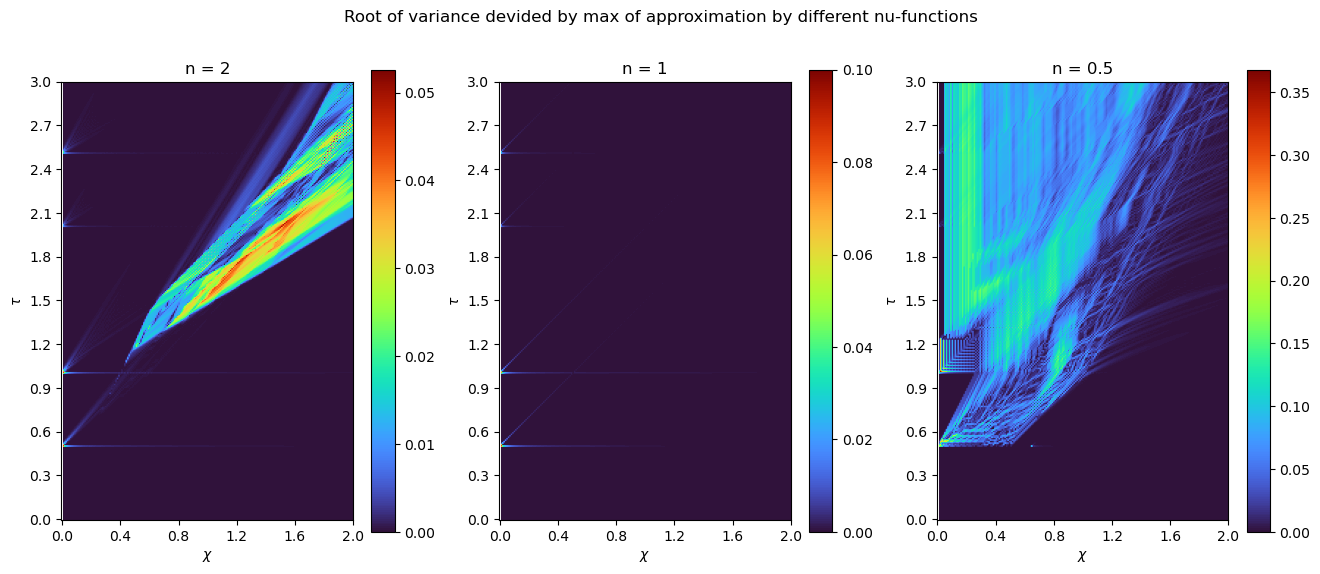

In [27]:
fig, axs = plt.subplots(1, len(ns))
fig.set_figheight(6)
fig.set_figwidth(5*len(ns) + 1)
fig.suptitle('Root of variance devided by max of approximation by different nu-functions')

xticks = np.linspace(0, len(chis), 6)
yticks = np.linspace(0, len(taus), 11)

for i, n in enumerate(ns):
    sols_n = nusols[:, i, :, :]
    
    axs[i].set_title(f'n = {n}')
    mappable = axs[i].imshow(sols_n.var(axis=0)**0.5/(sols_n.max(axis=0)), 
                             origin='lower', cmap='turbo')
    plt.colorbar(mappable)
    
    axs[i].set_xticks(xticks, np.round(xticks*dchi, 1))
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_yticks(yticks, np.round(yticks*dtau, 1))
    axs[i].set_ylabel(r'$\tau$')
    
fig.savefig('pics/Variance devided by max of approximation by different solving methods.png')

__Conclusion:__ In the cases of $n\ne1$ the the root variance devided by max value is more valueble, but not higher than 0.35.
The result is little less noisy, but the noise still exists.